83689472/83683744 [==============================] - 0s 0us/step
Epoch 1/10
1562/1562 [==============================] - 25s 10ms/step - loss: 1.9129
Epoch 2/10
1562/1562 [==============================] - 0s 21us/step - loss: 1.5355
INFO:tensorflow:Assets written to: fine_tuned_model/assets
313/313 [==============================] - 3s 8ms/step - loss: 1.5704


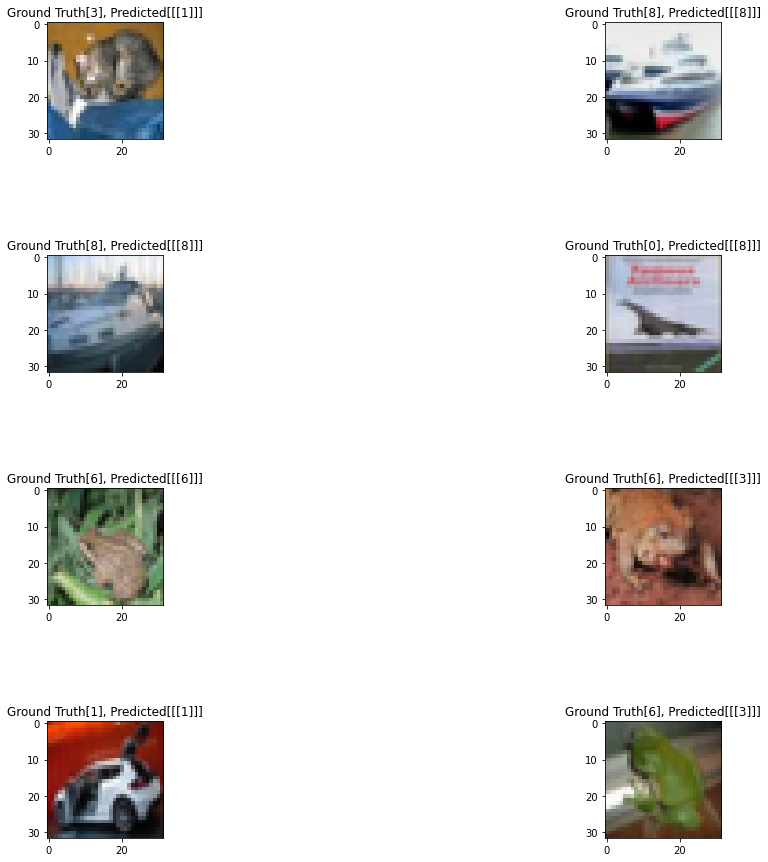

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

batch_size = 32

(x_train,y_train), (x_test,y_test) = tf.keras.datasets.cifar10.load_data()


def data_generator(data,label):
  dataset = tf.data.Dataset.from_tensor_slices((data,label))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

def show_img(dataset):
  plt.figure(figsize=(15,15))
  for i in range(8):
    for val in dataset.take(1):
      plt.subplot(4,2,i+1)
      img  = (val[0][i])
      plt.imshow(tf.cast(img,tf.uint8))
      y_pred = model.predict(np.expand_dims(val[0][i],axis=0))
      y_pred = np.argmax(y_pred,axis=-1)
      plt.title('Ground Truth{}, Predicted{}'.format(val[1][i],y_pred))
      plt.subplots_adjust(wspace=1, hspace=1)
  plt.show()

model_input = tf.keras.Input(shape=(32,32,3))

#Data Augmentation 
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(10),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(0.5,0.3)
])


x = data_augmentation(model_input)
#Rescaling and Resizing
x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)(x)
x = tf.keras.layers.experimental.preprocessing.Resizing(32,32,'nearest')(x)

base_model = tf.keras.applications.Xception(include_top=False,
                                            weights='imagenet',
                                            input_tensor=x)

for layer in base_model.layers[:-5]:
  layer.trainable = False

model_output = tf.keras.layers.Dense(10)(base_model.output)
model = tf.keras.models.Model(base_model.input,model_output)

model.compile(optimizer= tf.keras.optimizers.Adam(0.002),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

train_dataset = data_generator(x_train,y_train)
test_dataset = data_generator(x_test,y_test)

history = model.fit(train_dataset,batch_size=batch_size,epochs=10,
                    steps_per_epoch=len(x_train)//batch_size)

#Saving model in tf saved model format
model.save('fine_tuned_model')

evaluation = model.evaluate(test_dataset,batch_size=batch_size)

show_img(test_dataset)
